<a href="https://colab.research.google.com/github/yeefan1999/Explainable-Health-Prediction-with-Transfer-Learning/blob/main/colab/model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
import os,sys,inspect
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ZeroPadding2D,GlobalAveragePooling2D,Dense,Conv2D, Convolution2D, Flatten, Dropout, MaxPooling2D, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Input
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tqdm
import os
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from keras import applications
from keras.applications.vgg16 import preprocess_input
from keras.applications.imagenet_utils import decode_predictions
from keras.models import Model
from keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import keras
import sklearn.metrics as metrics
import seaborn as sns
from keras_vggface.vggface import VGGFace

In [11]:
import random
from scipy import ndimage

def load_data(datadir,categories):
    
    datalength = 0
    data = list()
    labels = list()
    for i,category in enumerate(categories):
        path = os.path.join(datadir, category)
        path_list = os.listdir(path)
        if ('.DS_Store') in path_list:
            path_list.remove('.DS_Store')
        for img in path_list:
            img_ = os.path.join(path,img)
            img_ = cv2.imread(img_)
            img_ = cv2.cvtColor(img_,cv2.COLOR_BGR2RGB)
            data.append(img_)

    return np.asarray(data)

def get_label_augmented_data(symptom,normal):
    """return train data and label"""
    data_normal = list()
    labels = list()
    data_symptoms = list()
    for image in normal:
        image2 = tf.image.flip_left_right(image)
        data_normal.append(np.asarray(image))
        data_normal.append(np.asarray(image2))
        data_normal.append(np.asarray(tf.image.rot90(image,tf.random.uniform(shape=[],
                                                                              minval=1,maxval=4,
                                                                             dtype=tf.int32))))
        data_normal.append(np.asarray(tf.image.random_brightness(image,max_delta=0.3)))
        image3 = ndimage.rotate(image,15)
        kernel = np.ones((5,5),np.float32)/25
        dst = cv2.filter2D(image,-1,kernel)
        data_normal.append(image3)
        data_normal.append(dst)

    for image in symptom:
        image2 = tf.image.flip_left_right(image)
        data_symptoms.append(np.asarray(image))
        data_symptoms.append(np.asarray(image2))
        data_symptoms.append(np.asarray(tf.image.rot90(image,tf.random.uniform(shape=[],
                                                                              minval=1,maxval=4,
                                                                             dtype=tf.int32))))
        data_symptoms.append(np.asarray(tf.image.random_brightness(image,max_delta=0.3)))
        image3 = ndimage.rotate(image,15)

        kernel = np.ones((5,5),np.float32)/25
        dst = cv2.filter2D(image,-1,kernel)
        data_symptoms.append(image3)
        data_symptoms.append(dst)
        
    train_data = np.concatenate((np.array(data_normal),
                       np.array(data_symptoms)))
    labels = np.concatenate((np.zeros(6000),np.ones(3600)))
        
    return train_data,labels


def haar_crop():

    path_symptoms = "Train/Symptoms_ori"
    path_normal = "Train/Normal_ori"

    savepath_symptoms = "Train/Symptoms_crop/"
    savepath_normal = "Train/Normal_crop/"

    facecascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

    found_faces = list()

    dirs = os.listdir(path_symptoms)

    if('.DS_Store' in dirs):
        dirs.remove('.DS_Store')

    i = 0

    for item in dirs:
        if os.path.isfile(path_symptoms+'/'+item):
            image = cv2.imread(path_symptoms+'/'+item)
            gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
            faces = facecascade.detectMultiScale(
                    gray,
                    scaleFactor=1.3,
                    minNeighbors=3,
                    minSize=(30,30))
            if(len(faces)==1):
                found_faces.append(item)
                for (x,y,w,h) in faces:
                    cv2.rectangle(image,(x,y),(x+w, y+h), (0,255,0),2)
                    roi_color = image[y+2:y+h-2, x+2:x+w-2]
                    cv2.imwrite(savepath_symptoms+item, roi_color)


    found_faces = list()

    dirs = os.listdir(path_normal)

    if('.DS_Store' in dirs):
        dirs.remove('.DS_Store')

    i = 0

    for item in dirs:
        if os.path.isfile(path_normal+'/'+item):
            image = cv2.imread(path_normal+'/'+item)
            gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
            faces = facecascade.detectMultiScale(
                    gray,
                    scaleFactor=1.3,
                    minNeighbors=3,
                    minSize=(30,30))
            if(len(faces)==1):
                found_faces.append(item)
                for (x,y,w,h) in faces:
                    cv2.rectangle(image,(x,y),(x+w, y+h), (0,255,0),2)
                    roi_color = image[y+2:y+h-2, x+2:x+w-2]
                    cv2.imwrite(savepath_normal+item, roi_color)




def resize_rename():
	path_symptoms = "Train/Symptoms_crop/"
	path_normal = "Train/Normal_crop/"
	save_path = "Train/Normal/"
	i = 0
	dirs = os.listdir(path_symptoms)
	dirs.remove('.DS_Store')
	for item in dirs:
	    if os.path.isfile(path_symptoms+item):
	        image = Image.open(path_symptoms+item)
	        image_resized = image.resize((200,200))
	        image_resized.save(save_path+str(i)+'_symptoms.jpg','PNG', quality=100)
	        i+=1

	save_path = "Train/Symptoms/"
	i = 0
	dirs = os.listdir(path_normal)
	dirs.remove('.DS_Store')
	for item in dirs:
	    if os.path.isfile(path_normal+item):
	        image = Image.open(path_normal+item)
	        image_resized = image.resize((200,200))
	        image_resized.save(save_path+str(i)+'_normal.jpg','PNG', quality=100)
	        i+=1
    


In [12]:
data_normal = load_data('/content/drive/My Drive/Augmentation Data',['Normal'])
data_symptoms = load_data('/content/drive/My Drive/Augmentation Data',['Symptoms'])

In [15]:
train_data = np.concatenate((np.array(data_normal),
                           np.array(data_symptoms)))
labels = np.concatenate((np.zeros(6000),np.ones(3600)))

## VGGFace



In [16]:
model = VGGFace(weights='vggface',
                        include_top=False,
                        input_shape=(200,200,3))

def create_features(dataset,model):
    
    train_data = np.expand_dims(dataset,axis=0)
    train_data = np.vstack(train_data)
    features = model.predict(train_data)
    features_flatten = features.reshape((features.shape[0],6*6*512))
    
    return train_data, features, features_flatten


58916864/58909280 [==============================] - 1s 0us/step


In [17]:
train_data, features, features_flatten = create_features(train_data,model)

In [18]:
X_train, X_valid, y_train,y_valid = train_test_split(features,labels,test_size=0.2,random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train,y_train,test_size=0.15,random_state=42)

In [19]:
checkpointer = ModelCheckpoint(filepath='/content/drive/My Drive/cnn_best.hdf5',verbose=1,
                              save_best_only=True)

In [20]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=10)
model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(6, 6, 512))) 
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu',padding="Same")) 
model.add(MaxPooling2D((2, 2)))



model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [21]:
model_history = model.fit(X_train,y_train,
                         epochs=100,
                         callbacks=[es,checkpointer],
                         verbose=2,
                         validation_data=(X_valid,y_valid))

Epoch 1/100
154/154 - 4s - loss: 0.6063 - accuracy: 0.8051 - val_loss: 0.2163 - val_accuracy: 0.9143

Epoch 00001: val_loss improved from inf to 0.21635, saving model to /content/drive/My Drive/cnn_best.hdf5
Epoch 2/100
154/154 - 3s - loss: 0.1834 - accuracy: 0.9231 - val_loss: 0.1820 - val_accuracy: 0.9212

Epoch 00002: val_loss improved from 0.21635 to 0.18201, saving model to /content/drive/My Drive/cnn_best.hdf5
Epoch 3/100
154/154 - 3s - loss: 0.1159 - accuracy: 0.9559 - val_loss: 0.1273 - val_accuracy: 0.9523

Epoch 00003: val_loss improved from 0.18201 to 0.12726, saving model to /content/drive/My Drive/cnn_best.hdf5
Epoch 4/100
154/154 - 3s - loss: 0.0812 - accuracy: 0.9683 - val_loss: 0.1035 - val_accuracy: 0.9654

Epoch 00004: val_loss improved from 0.12726 to 0.10349, saving model to /content/drive/My Drive/cnn_best.hdf5
Epoch 5/100
154/154 - 3s - loss: 0.0711 - accuracy: 0.9758 - val_loss: 0.0912 - val_accuracy: 0.9696

Epoch 00005: val_loss improved from 0.10349 to 0.09125

## Evaluate

In [22]:
print(model.evaluate(X_test,y_test))
predictions_ = model.predict(X_test)

28/28 [==============================] - 0s 6ms/step - loss: 0.1658 - accuracy: 0.9597
[0.16582632064819336, 0.9596773982048035]


In [23]:
predictions = np.argmax(predictions_, axis=1)

print(classification_report(y_test,predictions))
print("Accuracy:",accuracy_score(y_test,predictions))

              precision    recall  f1-score   support

         0.0       0.98      0.94      0.96       461
         1.0       0.93      0.98      0.96       407

    accuracy                           0.96       868
   macro avg       0.96      0.96      0.96       868
weighted avg       0.96      0.96      0.96       868

Accuracy: 0.9596774193548387


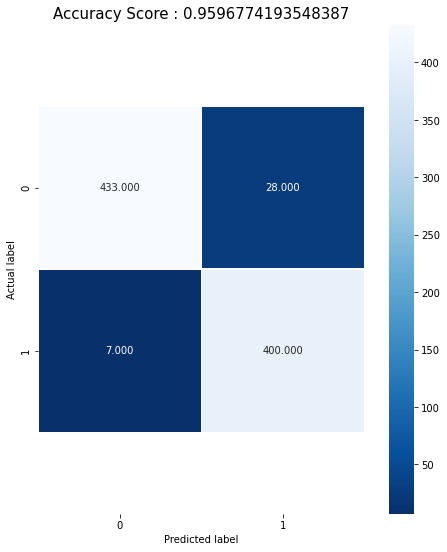

In [24]:
cnf_matrix = metrics.confusion_matrix(y_test, predictions)
cnf_matrix

cm = metrics.confusion_matrix(y_test, predictions)
score = accuracy_score(y_test,predictions)

plt.figure(figsize=(9,9))
ax = sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, 
                 square=True,cmap='Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score : {0}'.format(score)
plt.title(all_sample_title, size=15)

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.show()